# Azure AI Foundry Agent Service - Code Interpreterを使ったシングルエージェント

## 概要

このハンズオンでは、Azure AI Foundry Agent ServiceのCode Interpreter機能を使用して、データ分析や計算、グラフ作成を行うAIエージェントを作成します。

### 学習内容
- エージェントによる自動的なPythonコード生成と実行
- データ分析とグラフ可視化を行うエージェントの作成

# ライブラリのインポート

必要なPythonライブラリとAzure AI Foundry SDKをインポートします。

In [13]:
import os
import json
import datetime
import zoneinfo

import requests

from dotenv import load_dotenv, find_dotenv

from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import (
    ListSortOrder,
    CodeInterpreterTool,
    FunctionTool,
    ToolSet,
)
from IPython.display import Image, display

# 環境変数の取得

Azure AI Foundryへの接続に必要な設定情報を環境変数から取得します。

- `PROJECT_ENDPOINT`: Azure AI Foundryプロジェクトのエンドポイント
- `AZURE_DEPLOYMENT_NAME`: 使用するAIモデルのデプロイメント名

これらの値は事前に.envファイルに設定されている必要があります。

In [14]:
load_dotenv(override=True)

PROJECT_ENDPOINT=os.getenv("PROJECT_ENDPOINT")
AZURE_DEPLOYMENT_NAME=os.getenv("AZURE_DEPLOYMENT_NAME")

# クライアントの初期化

Azure AI Foundryプロジェクトへの接続とエージェント管理用のクライアントを初期化します。

- `AIProjectClient`: Azure AI Foundryプロジェクトとの接続を管理
- `DefaultAzureCredential`: Azure認証（Azure CLI、Managed Identity等を自動検出）
- `agents_client`: エージェントの作成・管理・実行を行うクライアント

In [15]:
# AI Project Client を初期化
project_client = AIProjectClient(
    endpoint=PROJECT_ENDPOINT,
    credential=DefaultAzureCredential()
)

# AgentClient の作成
agents_client = project_client.agents

# ユーティリティ関数

エージェントの実行結果を表示するためのヘルパー関数を定義します。

`agent_run_outputs`関数は以下の機能を提供します：
- スレッド内のメッセージ一覧を取得・表示
- 画像コンテンツがある場合は保存・表示

In [16]:
def agent_run_outputs(thread_id, agents_client, target_dir="./output_images"):
    """
    指定したスレッドIDのRun実行結果（テキスト・画像）をNotebook上に表示＆画像は保存。
    """
    messages = agents_client.messages.list(thread_id=thread_id, order=ListSortOrder.ASCENDING)
    os.makedirs(target_dir, exist_ok=True)

    for message in messages:
        # テキスト出力
        if message.text_messages:
            for txt in message.text_messages:
                print(f"{message.role.upper()}: {txt.text.value}")
        
        # 画像出力
        if hasattr(message, "image_contents"):
            for image_content in message.image_contents:
                file_id = image_content.image_file.file_id
                file_name = f"{file_id}_image_file.png"

                agents_client.files.save(
                    file_id=file_id,
                    file_name=file_name,
                    target_dir=target_dir
                )
                print(f"Saved image: {file_name}")
                display(Image(filename=f"{target_dir}/{file_name}"))

# ツールの定義

エージェントが使用できるツールを定義します。このノートブックでは2種類のツールを使用します。

## 使用するツール
1. **Code Interpreter**: Pythonコードの自動生成・実行、データ分析、グラフ作成
2. **カスタム関数**: 外部APIからのデータ取得（気温情報等）

これらのツールを組み合わせることで、データ取得から分析・可視化まで一連の処理を自動化できます。

## Code Interpreter

Code Interpreterは、エージェントがPythonコードを自動生成・実行する機能です。

### Code Interpreterの機能
- **データ分析**: pandas、numpyを使った統計処理
- **可視化**: matplotlib、seabornでのグラフ作成
- **計算処理**: 数学的計算や数値処理
- **ファイル操作**: CSV読み込み、画像保存等

エージェントは自然言語の要求を理解し、適切なPythonコードを生成して実行します。

In [17]:
# Code Interpreter ツールの定義
codeinterpreter = CodeInterpreterTool()

## カスタム関数

01のノートブックと同じカスタム関数を定義します。これらの関数でデータを取得し、Code Interpreterで分析・可視化を行います。

### 定義する関数
1. **get_prefecture_location**: 都道府県名から緯度・経度を取得
2. **get_current_time_jst**: 日本標準時の現在日付を取得
3. **get_temperature**: 指定座標・日付の気温を外部APIから取得

Code Interpreterと組み合わせることで、「データ取得 → 分析 → 可視化」の一連の流れを自動化できます。

In [18]:
def get_prefecture_location(prefecture: str) -> str:
    """
    都道府県名から緯度・経度を取得します。都道府県一覧・座標は変更しません。

    :param prefecture (str): 都道府県名（例: "東京都"）
    :rtype: str

    :return: {"latitude": ..., "longitude": ...} 形式のJSON文字列。見つからなければ {"latitude": null, "longitude": null}
    :rtype: str
    """
    json_path ="../../infra/sample_data/prefecture_locations.json"
    with open(json_path, "r", encoding="utf-8") as f:
        PREFECTURE_LOCATIONS = json.load(f)
        
    loc = PREFECTURE_LOCATIONS.get(prefecture)
    if loc:
        return json.dumps({"latitude": loc[0], "longitude": loc[1]})
    else:
        return json.dumps({"latitude": None, "longitude": None})


def get_current_time_jst() -> str:
    """
    日本標準時（JST, UTC+9）の今日の日付を "YYYY-MM-DD" 形式の文字列で返します。日時情報は変更しません。

    :rtype: str

    :return: 今日の日付（"YYYY-MM-DD" 形式の文字列）
    :rtype: str
    """
    jst = zoneinfo.ZoneInfo("Asia/Tokyo")
    now = datetime.datetime.now(jst)
    return now.strftime("%Y-%m-%d")


def get_temperature(latitude: float, longitude: float, date: str) -> str:
    """
    指定した緯度・経度と日付に基づき、Open-Meteo APIで該当日の平均気温（摂氏）を返します。
    外部サービスのみ参照し、情報は変更しません。

    :param latitude (float): 緯度
    :param longitude (float): 経度
    :param date (str): 日付（"YYYY-MM-DD" 形式）
    :rtype: str

    :return: 指定日の平均気温（摂氏）をJSON文字列で返します。データがなければ {"temperature": null}。
    :rtype: str
    """
    url = (
        "https://api.open-meteo.com/v1/forecast"
        f"?latitude={latitude}&longitude={longitude}"
        f"&start_date={date}&end_date={date}"
        "&daily=temperature_2m_mean"
        "&timezone=Asia%2FTokyo"
    )
    resp = requests.get(url, timeout=5)
    resp.raise_for_status()
    data = resp.json()
    temps = data.get("daily", {}).get("temperature_2m_mean", [])
    value = temps[0] if temps else None
    return json.dumps({"temperature": value})


## Toolset に格納

定義したツール（Code InterpreterとカスタムFunction）をエージェントが使用できる形式（ToolSet）に格納します。

### ツールセットの構成
- `CodeInterpreterTool`: Python実行環境とデータ分析・可視化機能
- `FunctionTool`: 外部APIとの連携機能
- `enable_auto_function_calls`: 自動関数呼び出し設定

この設定により、エージェントは必要に応じてデータを取得し、それをCode Interpreterで分析・可視化できるようになります。

In [19]:
# Toolset の作成＆関数の追加
toolset = ToolSet()

# Code Interpreter ツールを追加
toolset.add(codeinterpreter)

# カスタム関数ツールの定義
functions = FunctionTool(functions={get_prefecture_location, get_current_time_jst, get_temperature})
toolset.add(functions)

# エージェントで関数を自動的に呼び出すように設定
agents_client.enable_auto_function_calls(functions)

# エージェントの作成

Foundry エージェントを作成します。

In [20]:
code_interpreter_agent = agents_client.create_agent(
    model=AZURE_DEPLOYMENT_NAME,
    name="code_interpreter_agent",
    instructions=(
        "あなたは日本国内の気温や地理情報に答えたり、計算や図表の出力に特化したアシスタントです。"
        "利用可能なツールを確認し、必要に応じて使用してください。"    
        "なお、グラフを描画する際は日本語が文字化けするため、ラベルやタイトルは英語で出力してください。"    
    ),
    description=(
        "Code Interpreter を利用して、計算や図表の出力に特化した分析アシスタントです。"
    ),
    tools=toolset.definitions,
)
print(f"Created Agent. AGENT_ID: {code_interpreter_agent.id}")


Created Agent. AGENT_ID: asst_bPT5srIuEnJ5oCFM7udXbQIe


# スレッドの作成

エージェントとの対話を管理するスレッドを作成します。

In [21]:
# Thread の作成
thread = agents_client.threads.create()
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: thread_JKN0Dy4muBmao2P6QsrsHOhS


# ユーザーメッセージの追加

スレッドにユーザーからの質問やリクエストを追加します。

In [22]:
user_message_01= (
    "過去5日間の東京都、沖縄県の平均気温を調べてください。"
    "また、それをグラフで出力してください。"
)

message = agents_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=user_message_01,
)

print(f"Added Message. MESSAGE_ID: {message.id}")

Added Message. MESSAGE_ID: msg_D93QTbHpwPJDfz4zlKe4WqWq


# Run の実行

エージェントにタスクを実行させ、結果を取得します。

USER: 過去5日間の東京都、沖縄県の平均気温を調べてください。また、それをグラフで出力してください。
ASSISTANT: 上記グラフは、過去5日間（7月26日～7月30日）の東京都と沖縄県の平均気温の推移を示しています。

- 東京都: 28.8°C, 28.5°C, 28.0°C, 28.0°C, 27.2°C
- 沖縄県: 28.5°C, 28.2°C, 28.0°C, 28.5°C, 28.5°C（最終日は取得できなかったため直前値で補完）

ご参考ください。さらに詳しいデータ分析や他地域との比較も可能ですので、ご希望があればお知らせください。
Saved image: assistant-NqjUGLvtdpnvz8WY5udDhA_image_file.png


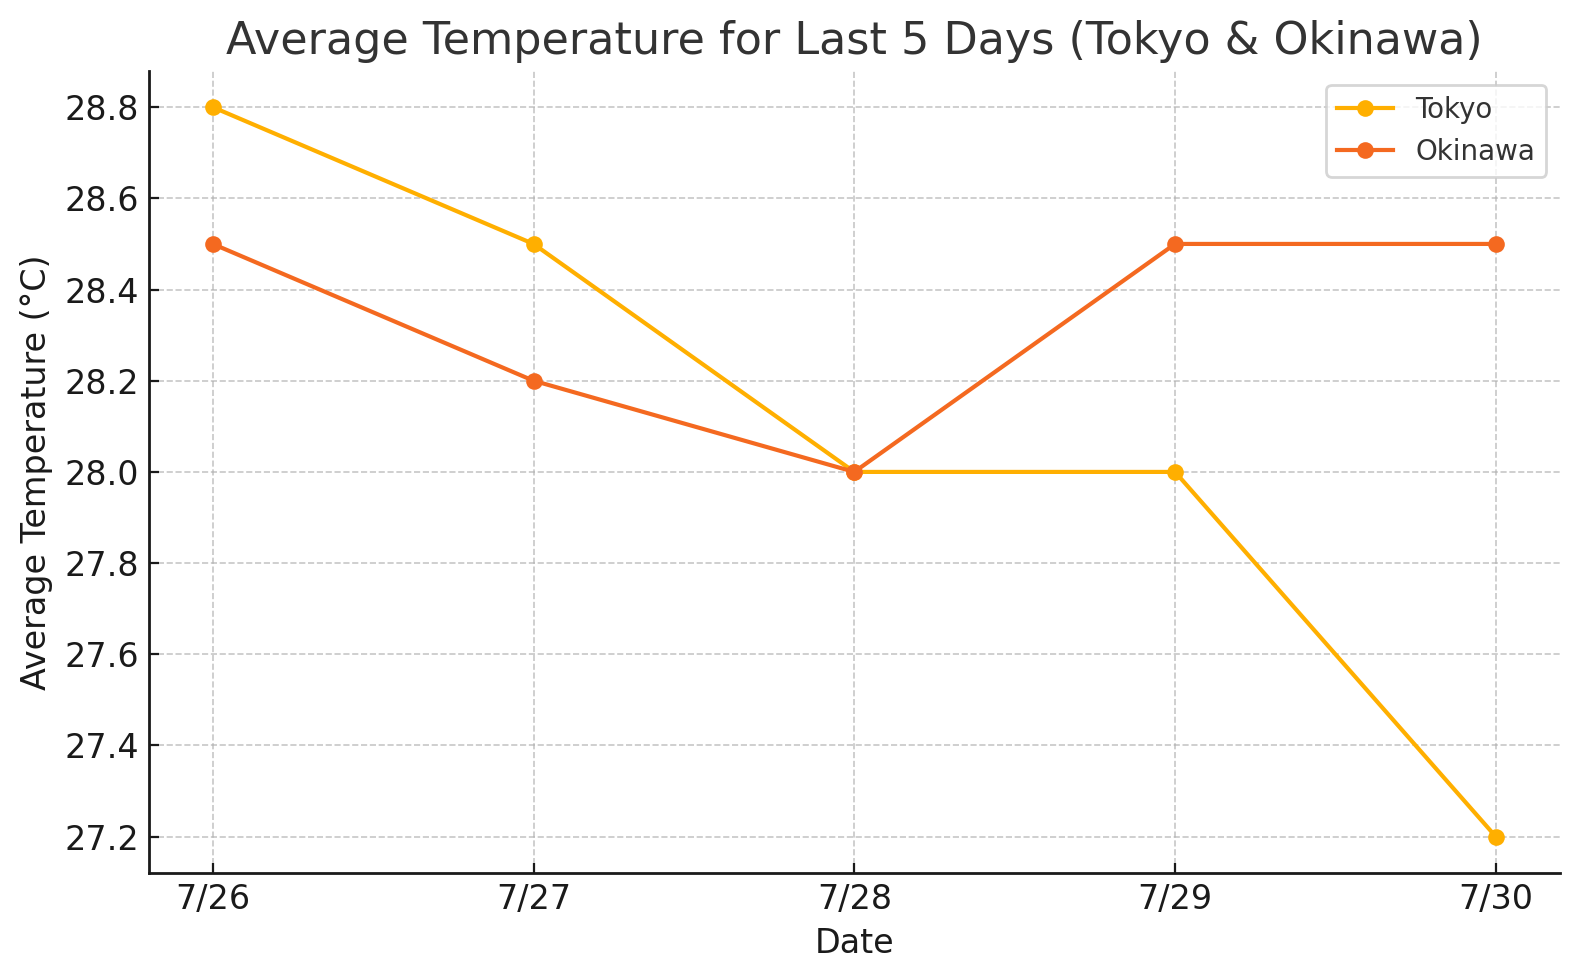

ASSISTANT: 東京都と沖縄県の過去5日間の平均気温は以下の通りでした。

| 日付      | 東京都(℃) | 沖縄県(℃)  |
|-----------|-----------|------------|
| 7/26      | 28.8      | 28.5       |
| 7/27      | 28.5      | 28.2       |
| 7/28      | 28.0      | 28.0       |
| 7/29      | 28.0      | 28.5       |
| 7/30      | 27.2      | 28.5（※）  |

※7/30の沖縄県の値は取得できなかったため、前日の値(28.5℃)で補完しています。

以下がグラフです（ラベル等は英語表記です）：


In [25]:
run = agents_client.runs.create_and_process(
    thread_id=thread.id,
    agent_id=code_interpreter_agent.id
)

if run.status == "failed":
    print(f"Run failed: {run.last_error}")
else:
    agent_run_outputs(thread.id, agents_client)

# トレースの確認

[Azure AI Foundry Portal](https://ai.azure.com/?cid=learnDocs) でエージェントの実行トレースを確認してみましょう。

# Agent ID を .env ファイルに保存
※ 今回作成したエージェントを、後続のハンズオン演習で使用するため永続化します。

In [24]:
# 変数の定義
agent_env_key = "FOUNDRY_CODE_INTERPRETER_AGENT_ID"
agent_env_value = code_interpreter_agent.id

# .envファイルのパスを自動探索
env_path = find_dotenv() 
if not env_path:
    raise FileNotFoundError(".envファイルが見つかりませんでした。")

# AGENT_ID を .env ファイルに追記
with open(env_path, "a", encoding="utf-8") as f:
    f.write(f'\n{agent_env_key}="{agent_env_value}"')

print(f'.envファイルに {agent_env_key}=\"{agent_env_value}\" を追記しました。')


.envファイルに FOUNDRY_CODE_INTERPRETER_AGENT_ID="asst_bPT5srIuEnJ5oCFM7udXbQIe" を追記しました。
